In [1]:
import pandas as pd
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.vgg19 import VGG19
from scipy.optimize import fmin_l_bfgs_b
import tensorflow as tf

In [2]:
# Load the Image
base_image_path = "profile_pic.jpg"
style_image_path = "style.jpg"

In [3]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)
print(img_ncols)

359


In [4]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

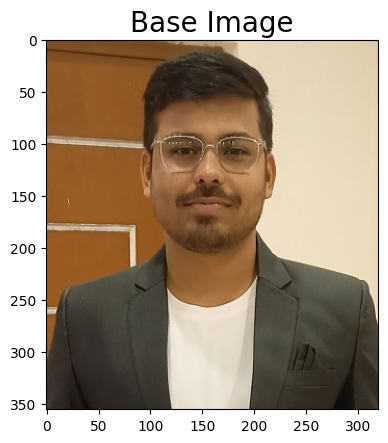

In [5]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img("profile_pic.jpg")
plt.imshow(img1)

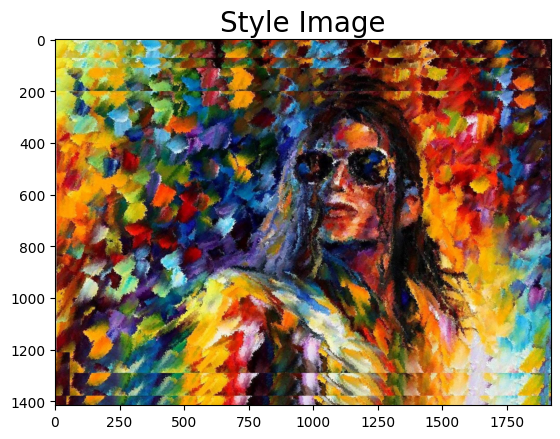

In [6]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img("style.jpg")
plt.imshow(img1)

In [7]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [8]:
K.image_data_format()

'channels_last'

In [9]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [10]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

  <tf.Variable 'Variable:0' shape=(1, 400, 359, 3) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.


In [11]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
# Download the weights file from "https://www.kaggle.com/datasets/keras/vgg19/?select=vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg19_weights = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)

In [12]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

KerasTensor(type_spec=TensorSpec(shape=(3, 25, 22, 512), dtype=tf.float32, name=None), name='block5_conv2/Relu:0', description="created by layer 'block5_conv2'")


In [14]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [15]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))

In [26]:
content_weight=0.025
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


Layer Feature for Content Layers :: KerasTensor(type_spec=TensorSpec(shape=(3, 25, 22, 512), dtype=tf.float32, name=None), name='block5_conv2/Relu:0', description="created by layer 'block5_conv2'")
Base Image Feature :: KerasTensor(type_spec=TensorSpec(shape=(25, 22, 512), dtype=tf.float32, name=None), name='tf.__operators__.getitem_24/strided_slice:0', description="created by layer 'tf.__operators__.getitem_24'")
Combination Image Feature for Content Layers:: KerasTensor(type_spec=TensorSpec(shape=(25, 22, 512), dtype=tf.float32, name=None), name='tf.__operators__.getitem_25/strided_slice:0', description="created by layer 'tf.__operators__.getitem_25'")



TypeError: ignored

In [ ]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

In [ ]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [ ]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [ ]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [ ]:
evaluator = Evaluator()

In [ ]:
iterations=400
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss,
                                        x_opt.flatten(),
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss.
        best_loss = min_val
        best_img = x_opt.copy()

In [ ]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)